<a href="https://colab.research.google.com/github/spyysalo/consensus-pipeline/blob/master/ptm_triage_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quick initial experiments for training a model for selecting documents mentioning PTM catalysis.

In [1]:
!pip install --quiet transformers datasets evaluate

In [2]:
from datasets import Dataset


dataset = Dataset.from_json('http://dl.turkunlp.org/ptm/ptm-triage.jsonl')

In [3]:
dataset = dataset.shuffle(seed=42)
dataset = dataset.class_encode_column('label')
dataset = dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")

In [4]:
label_names = dataset['train'].features['label'].names
num_labels = len(label_names)
id2label = { k: v for k, v in enumerate(label_names) }
label2id = { v: k for k, v in enumerate(label_names) }

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


MODEL = 'dmis-lab/biobert-base-cased-v1.2'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [6]:
def tokenize(example):
  return tokenizer(example['text'], truncation=True, max_length=512)

dataset = dataset.map(tokenize)

In [7]:
import evaluate


f1 = evaluate.load('f1')

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)
    return f1.compute(predictions=predictions, references=labels)

In [8]:
from collections import defaultdict

from transformers import TrainerCallback


class LogSavingCallback(TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != 'epoch' or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

In [9]:
from transformers import TrainingArguments


trainer_args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='steps',
    logging_strategy='steps',
    load_best_model_at_end=True,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=200,
)

In [10]:
from transformers import Trainer


trainer = Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_accuracy,
    tokenizer=tokenizer,
    callbacks=[training_logs], 
)

max_steps is given, it will override any value given in num_train_epochs


In [11]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 187
  Num Epochs = 9
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 200
  Number of trainable parameters = 108311810
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to

Step,Training Loss,Validation Loss,F1
10,0.563400,0.532183,0.000000
20,0.565100,0.526910,0.000000
30,0.515300,0.524163,0.000000
40,0.519400,0.498106,0.000000
50,0.490600,0.478326,0.000000
60,0.378500,0.454575,0.000000
70,0.372200,0.452091,0.000000
80,0.273500,0.437823,0.470588
90,0.222300,0.465396,0.285714
100,0.132000,0.558040,0.000000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 32
The following colum

TrainOutput(global_step=200, training_loss=0.2530375072360039, metrics={'train_runtime': 184.0214, 'train_samples_per_second': 8.695, 'train_steps_per_second': 1.087, 'total_flos': 404095928264220.0, 'train_loss': 0.2530375072360039, 'epoch': 8.33})

In [12]:
eval_results = trainer.evaluate(dataset['test'])

print(eval_results)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 47
  Batch size = 32


{'eval_loss': 0.5518630743026733, 'eval_f1': 0.14285714285714288, 'eval_runtime': 1.5472, 'eval_samples_per_second': 30.377, 'eval_steps_per_second': 1.293, 'epoch': 8.33}


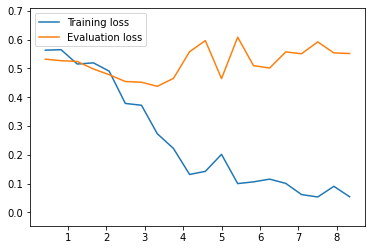

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(min(values)-0.1, max(values)+0.1)
    for key, label in zip(keys, labels):    
        plt.plot(logs['epoch'], logs[key], label=label)
    plt.legend()
    plt.show()

plot(
    training_logs.logs,
    ['loss', 'eval_loss'],
    ['Training loss', 'Evaluation loss']
)

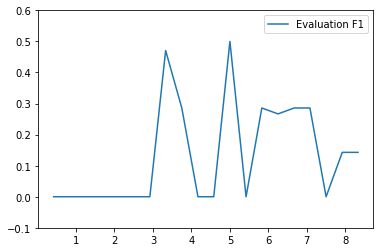

In [14]:
plot(training_logs.logs, ['eval_f1'], ['Evaluation F1'])